In [1]:
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as display

sys.path.append('../src')
import const
from metrics import row_wise_micro_averaged_f1_score

pd.options.display.max_rows=120

In [2]:
def fill_dropped(dropped_array, drop_idx):
    filled_array = np.zeros(
        (len(dropped_array) + len(drop_idx), dropped_array.shape[1])
    )
    idx_array = np.arange(len(filled_array))
    use_idx = np.delete(idx_array, drop_idx)
    filled_array[use_idx, :] = dropped_array
    return filled_array

In [3]:
def extract_label(preds, th=0.5):
    events = preds >= th
    nocall_col = np.zeros((len(preds), 1)).astype(bool)
    nocall_col[events.sum(1) == 0] = True
    events = np.concatenate([events, nocall_col], axis=1)
    
    predict_labels = []
    for i in range(len(events)):
        event = events[i, :]
        labels = np.argwhere(event).reshape(-1).tolist()
        
        row_labels = []
        for label in labels:
            row_labels.append(const.INV_BIRD_CODE[label])
        predict_labels.append(" ".join(row_labels))

    return predict_labels

In [4]:
def plot_oof(idx):
    plt.figure(figsize=(16, 5))
    plt.plot(oof[idx, :])
    
    top5_bc = np.argsort(oof[idx, :])[-5:]
    
    for bc in range(len(oof[idx, :])):
        if bc in top5_bc:
            plt.text(bc, oof[idx, bc] - oof[idx, :].max() * 0.05, s=const.INV_BIRD_CODE[bc])

In [5]:
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

val_y_labels = valid_df["birds"].tolist()

In [244]:
# oof4 = np.load("../logs/exp_004_20210409202215_0.701/oof.npy")
# oof10 = np.load("../logs/exp_010_20210412203406_0.684/oof.npy")
# oof11 = np.load("../logs/exp_011_20210413092718_0.710/oof.npy")
# oof12 = np.load("../logs/exp_012_20210413202510_0.700/oof.npy")
# oof20 = np.load("../logs/exp_020_20210420203023_0.698/oof.npy")
# oof21 = np.load("../logs/exp_021_20210421105635_0.701/oof.npy")
# oof22 = np.load("../logs/exp_022_20210421213519_0.712/oof.npy")
# oof23 = np.load("../logs/exp_023_20210422072541_0.696/oof.npy")
# oof24 = np.load("../logs/exp_024_20210422215622_0.684/oof.npy")
# oof25 = np.load("../logs/exp_025_20210423142123_0.684/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# # oof29 = np.load("../logs/exp_029_20210425212038_0.675/oof.npy")
# # oof32 = np.load("../logs/exp_032_20210426185313_0.684/oof.npy")
# # oof33 = np.load("../logs/exp_033_20210426230524_0.701/oof.npy")
# # oof34 = np.load("../logs/exp_034_20210427025324_0.686/oof.npy")
# # oof35 = np.load("../logs/exp_035_20210427085305_0.690/oof.npy")

# oof40 = np.load("../logs/exp_040_20210428095746_0.696/oof.npy")
# oof41 = np.load("../logs/exp_041_20210428173715_0.689/oof.npy")
# oof42 = np.load("../logs/exp_042_20210429120526_0.692/oof.npy")
# oof43 = np.load("../logs/exp_043_20210429195623_0.697/oof.npy")
# oof44 = np.load("../logs/exp_044_20210429235301_0.707/oof.npy")
# oof45 = np.load("../logs/exp_045_20210430131333_0.695/oof.npy")
# oof50 = np.load("../logs/exp_050_20210502230529_0.679/oof.npy")
# oof51 = np.load("../logs/exp_051_20210503030848_0.694/oof.npy")
# oof52 = np.load("../logs/exp_052_20210503093904_0.692/oof.npy")

# oof54 = np.load("../logs/exp_054_20210503234704_0.685/oof.npy")
# oof55 = np.load("../logs/exp_055_20210504024705_0.693/oof.npy")
# oof55 = oof54 * 0.5 + oof55 * 0.5

# oof56 = np.load("../logs/exp_056_20210504114210_0.697/oof.npy")
# oof57 = np.load("../logs/exp_057_20210504153605_0.690/oof.npy")
# oof58 = np.load("../logs/exp_058_20210504202445_0.679/oof.npy")
# oof60 = np.load("../logs/exp_060_20210505181921_0.706/oof.npy")
# oof61 = np.load("../logs/exp_061_20210505232548_0.656/oof.npy")
# oof62 = np.load("../logs/exp_062_20210506032156_0.648/oof.npy")
# oof65 = np.load("../logs/exp_065_20210507102634_0.640/oof.npy")
# oof65 = fill_dropped(oof65, drop_idx)
# oof66 = np.load("../logs/exp_066_20210507141914_0.637/oof.npy")
# oof66 = fill_dropped(oof66, drop_idx)
# oof67 = np.load("../logs/exp_067_20210507230447_0.629/oof.npy")
# oof68 = np.load("../logs/exp_068_20210508025654_0.620/oof.npy")
# oof74 = np.load("../logs/exp_074_20210509223155_3.172/oof.npy")
# oof74 = fill_dropped(oof74, drop_idx)
# oof76 = np.load("../logs/exp_076_20210511000515_0.629/oof.npy")
# oof76 = fill_dropped(oof76, drop_idx)
# oof77 = np.load("../logs/exp_077_20210511035734_0.629/oof.npy")
# oof77 = fill_dropped(oof77, drop_idx)
# oof78 = np.load("../logs/exp_078_20210511074917_0.633/oof.npy")
# oof78 = fill_dropped(oof78, drop_idx)
# oof81 = np.load("../logs/exp_081_20210511225340_0.636/oof.npy")
# oof81 = fill_dropped(oof81, drop_idx)
# oof82 = np.load("../logs/exp_082_20210512024531_0.625/oof.npy")
# oof82 = fill_dropped(oof82, drop_idx)
# oof86 = np.load("../logs/exp_086_20210512183544_0.632/oof.npy")
# oof86 = fill_dropped(oof86, drop_idx)
# oof87 = np.load("../logs/exp_087_20210512231955_0.619/oof.npy")
# oof87 = fill_dropped(oof87, drop_idx)
# oof88 = np.load("../logs/exp_088_20210513031332_0.628/oof.npy")
# oof88 = fill_dropped(oof88, drop_idx)
# oof89 = np.load("../logs/exp_089_20210513093810_0.627/oof.npy")
# oof89 = fill_dropped(oof89, drop_idx)
# oof91 = np.load("../logs/exp_091_20210514120344_0.639/oof.npy")
# oof91 = fill_dropped(oof91, drop_idx)
# oof92 = np.load("../logs/exp_092_20210514160253_0.650/oof.npy")
# oof92 = fill_dropped(oof92, drop_idx)
# oof93 = np.load("../logs/exp_093_20210514195743_0.630/oof.npy")
# oof93 = fill_dropped(oof93, drop_idx)
# oof95 = np.load("../logs/exp_095_20210515002049_0.633/oof.npy")
# oof95 = fill_dropped(oof95, drop_idx)
# oof96 = np.load("../logs/exp_096_20210515042121_0.636/oof.npy")
# oof96 = fill_dropped(oof96, drop_idx)
# oof97 = np.load("../logs/exp_097_20210515081329_0.653/oof.npy")
# oof97 = fill_dropped(oof97, drop_idx)
# oof100 = np.load("../logs/exp_100_20210516094037_0.620/oof.npy")
# oof100 = fill_dropped(oof100, drop_idx)
# oof101 = np.load("../logs/exp_101_20210516134723_0.650/oof.npy")
# oof101 = fill_dropped(oof101, drop_idx)
# oof102 = np.load("../logs/exp_102_20210516214845_0.620/oof.npy")
# oof102 = fill_dropped(oof102, drop_idx)
# oof106 = np.load("../logs/exp_106_20210519022652_0.601/oof.npy")
# oof106 = fill_dropped(oof106, drop_idx)
oof112 = np.load("../logs/exp_112_20210520045116_0.638/oof.npy")
oof112 = fill_dropped(oof112, drop_idx)
oof114 = np.load("../logs/exp_114_20210520192947_0.650/oof.npy")
oof114 = fill_dropped(oof114, drop_idx)
oof115 = np.load("../logs/exp_115_20210520232446_0.631/oof.npy")
oof115 = fill_dropped(oof115, drop_idx)
oof116 = np.load("../logs/exp_116_20210521031557_0.641/oof.npy")
oof116 = fill_dropped(oof116, drop_idx)
oof117 = np.load("../logs/exp_117_20210521070917_0.640/oof.npy")
oof117 = fill_dropped(oof117, drop_idx)
oof118 = np.load("../logs/exp_118_20210521110036_0.653/oof.npy")
oof118 = fill_dropped(oof118, drop_idx)
oof121 = np.load("../logs/exp_121_20210521215739_0.637/oof.npy")
oof121 = fill_dropped(oof121, drop_idx)

oof129 = np.load("../logs/exp_129_20210523145254_0.641/oof.npy")
oof129 = fill_dropped(oof129, drop_idx)
oof131 = np.load("../logs/exp_131_20210524005536_0.641/oof.npy")
oof131 = fill_dropped(oof131, drop_idx)
oof132 = np.load("../logs/exp_132_20210524061303_0.623/oof.npy")
oof132 = fill_dropped(oof132, drop_idx)
oof133 = np.load("../logs/exp_133_20210524105841_0.630/oof.npy")
oof133 = fill_dropped(oof133, drop_idx)
oof134 = np.load("../logs/exp_134_20210524160839_0.636/oof.npy")
oof134 = fill_dropped(oof134, drop_idx)
oof135 = np.load("../logs/exp_135_20210524214504_0.649/oof.npy")
oof135 = fill_dropped(oof135, drop_idx)
oof136 = np.load("../logs/exp_136_20210525032138_0.623/oof.npy")
oof136 = fill_dropped(oof136, drop_idx)
oof137 = np.load("../logs/exp_137_20210525173848_0.631/oof.npy")
oof137 = fill_dropped(oof137, drop_idx)
oof139 = np.load("../logs/exp_139_20210526031224_0.661/oof.npy")
oof139 = fill_dropped(oof139, drop_idx)
oof140 = np.load("../logs/exp_140_20210525120925_0.577/oof.npy")
oof140 = fill_dropped(oof140, drop_idx)
oof142 = np.load("../logs/exp_142_20210526125837_0.651/oof.npy")
oof142 = fill_dropped(oof142, drop_idx)

# nocall classification
oof59 = np.load("../logs/exp_059_20210505100513_0.666/oof.npy")
oof70 = np.load("../logs/exp_070_20210508193023_0.882/oof.npy")
oof79 = np.load("../logs/exp_079_20210511132329_0.874/oof.npy")
oof83 = np.load("../logs/exp_083_20210512081958_0.827/oof.npy")
oof99 = np.load("../logs/exp_099_20210515202257_0.859/oof.npy")

In [259]:
oof_list = [
    oof112,
    oof114,
    oof115,
    oof116,
    oof117,
    oof118,

    oof129,
    oof131,
    oof132,
#     oof137,
    oof139,
]

concat_oof = []
for oof_ in oof_list:
    concat_oof.append(oof_[np.newaxis, :, :])
concat_oof = np.concatenate(concat_oof)

In [260]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
oof_labels = extract_label(oof, th=0.26)

In [9]:
score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
score

0.7035784313725466

In [10]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds


def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v10(preds, pred_labels, df, window_size=1, c=2.0):
    first_labels = []
    for idx in df.index:
        row_prob = preds[idx, :]
        second_prob = np.sort(row_prob)[-2]

        first_label_bc = np.argmax(row_prob)
        v = row_prob[first_label_bc]
        if v >= (second_prob * c):
            first_labels.append(const.INV_BIRD_CODE[first_label_bc])
        else:
            first_labels.append("nocall")

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(first_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [11]:
post_oof = post_process_v2_plus(oof, valid_df, c=2.5, q=0.99, w=2.0)
oof_labels_ = extract_label(post_oof, th=0.65)
post_oof_labels = post_process_v10(post_oof, oof_labels_, valid_df, window_size=5, c=2.0)

In [12]:
score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
score

0.7472385620915006

In [13]:
valid_df["oof_birds"] = oof_labels
valid_df["post_oof_birds"] = post_oof_labels

oof_argsort_array = np.argsort(oof, axis=1)[:, ::-1]

valid_df["first_label"] = oof_argsort_array[:, 0]
valid_df["second_label"] = oof_argsort_array[:, 1]
valid_df["third_label"] = oof_argsort_array[:, 2]

valid_df["first_label"] = valid_df["first_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["second_label"] = valid_df["second_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["third_label"] = valid_df["third_label"].apply(lambda x: const.INV_BIRD_CODE[x])

In [14]:
valid_df["nocall_birds"] = 0
valid_df.loc[valid_df[valid_df["birds"] == "nocall"].index, "nocall_birds"] = 1

valid_df["nocall_oof_birds"] = 0
valid_df.loc[valid_df[valid_df["oof_birds"] == "nocall"].index, "nocall_oof_birds"] = 1

In [15]:
valid_df["acc"] = valid_df["birds"] == valid_df["oof_birds"]
valid_df.head()

,row_id,site,audio_id,seconds,birds,oof_birds,post_oof_birds,first_label,second_label,third_label,nocall_birds,nocall_oof_birds,acc
0,11254_COR_5,COR,11254,5,rubwre1,wbwwre1,wbwwre1,wbwwre1,orbeup1,rubwre1,0,0,False
1,11254_COR_10,COR,11254,10,nocall,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,1,0,False
2,11254_COR_15,COR,11254,15,rubwre1,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,0,0,False
3,11254_COR_20,COR,11254,20,nocall,nocall,nocall,meapar,creoro1,fepowl,1,1,True
4,11254_COR_25,COR,11254,25,rubwre1,rubwre1,rubwre1,rubwre1,baywre1,wbwwre1,0,0,True


In [130]:
valid_df["diff"] = (valid_df["birds"].apply(lambda x: 1 if x == "nocall" else 0) - 
                                 valid_df["oof_birds"].apply(lambda x: 1 if x == "nocall" else 0))
valid_df["diff_pattern"] = valid_df["diff"].map({-1: "bird -> nocall", 0: "birdX -> birdY", 1: "nocall -> bird"})
valid_df["birdcall_p"] = oof79.reshape(-1)

# usecols = ["row_id", "seconds", "birds", "oof_birds", "post_oof_birds", "first_label", "second_label", "third_label", "birdcall_p"]
usecols = ["row_id", "seconds", "birds", "post_oof_birds", "first_label", "second_label", "third_label", "birdcall_p"]

In [131]:
valid_df["diff_pattern"].value_counts()

birdX -> birdY    1517
bird -> nocall     444
nocall -> bird      79
Name: diff_pattern, dtype: int64

何かしらの鳥の鳴き声が聞こえているのに `nocall`と予測しているパターンが多い

In [132]:
valid_df[~valid_df["acc"]]

,row_id,site,audio_id,seconds,birds,oof_birds,post_oof_birds,first_label,second_label,third_label,nocall_birds,nocall_oof_birds,acc,diff,diff_pattern,birdcall_p,div
0,11254_COR_5,COR,11254,5,rubwre1,wbwwre1,wbwwre1,wbwwre1,orbeup1,rubwre1,0,0,False,0,birdX -> birdY,1.000000,2.921840
1,11254_COR_10,COR,11254,10,nocall,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,1,0,False,1,nocall -> bird,1.000000,14.133185
2,11254_COR_15,COR,11254,15,rubwre1,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,0,0,False,0,birdX -> birdY,1.000000,2.557489
6,11254_COR_35,COR,11254,35,nocall,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,1,0,False,1,nocall -> bird,0.999982,4.919792
7,11254_COR_40,COR,11254,40,nocall,wbwwre1,nocall,wbwwre1,bucmot2,rubwre1,1,0,False,1,nocall -> bird,0.855455,13.341797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,54955_SSW_560,SSW,54955,560,grycat,nocall,nocall,gwfgoo,grhowl,grycat,0,1,False,-1,bird -> nocall,0.617323,1.904893
2033,54955_SSW_570,SSW,54955,570,grycat,nocall,nocall,grycat,blujay,buggna,0,1,False,-1,bird -> nocall,0.091170,8.274531
2034,54955_SSW_575,SSW,54955,575,chswar,nocall,nocall,chswar,canwar,wlswar,0,1,False,-1,bird -> nocall,0.986755,4.726333
2036,54955_SSW_585,SSW,54955,585,grycat,nocall,nocall,amered,warvir,mallar3,0,1,False,-1,bird -> nocall,0.419688,1.843833


In [133]:
gp = valid_df.groupby("audio_id")

for audio_id, audio_df in gp:
    idxs = audio_df.index.values
    score = row_wise_micro_averaged_f1_score( valid_df.loc[idxs, "birds"].values, valid_df.loc[idxs, "oof_birds"])

    print(f"audio_id: {audio_id}\n score: {score:.4f}   nocall_mean: {1 - audio_df['birdcall_p'].mean():.4f}")
    print("-" * 50)
    print(audio_df['birds'].value_counts())
    print("\n")
    print(audio_df['oof_birds'].value_counts())
    print("\n")
    print(audio_df[~valid_df["acc"]]["diff_pattern"].value_counts())
    print("\n" * 2)

audio_id: 2782
 score: 0.3247   nocall_mean: 0.0036
--------------------------------------------------
eawpew reevir1                  37
reevir1                         23
bkcchi eawpew reevir1           20
eawpew grycat reevir1           16
grycat reevir1                   9
bkcchi reevir1                   8
bkcchi eawpew grycat reevir1     3
bkcchi grycat reevir1            2
chswar eawpew grycat reevir1     1
chswar eawpew reevir1            1
Name: birds, dtype: int64


nocall            62
reevir1           29
grycat            17
eawpew             9
grycat obnthr1     2
obnthr1            1
Name: oof_birds, dtype: int64


bird -> nocall    62
birdX -> birdY    44
Name: diff_pattern, dtype: int64



audio_id: 7843
 score: 0.9667   nocall_mean: 0.7868
--------------------------------------------------
nocall    116
bkcchi      2
blujay      2
Name: birds, dtype: int64


nocall    120
Name: oof_birds, dtype: int64


bird -> nocall    4
Name: diff_pattern, dtype: int64



audio_id

<ipython-input-133-814b63d3dbcd>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[~valid_df["acc"]]["diff_pattern"].value_counts())


## audio_id: 2782

In [134]:
idx = valid_df[valid_df["audio_id"] == 2782].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
960,2782_SSW_5,5,bkcchi grycat reevir1,grycat,grycat,gbwwre1,obnthr1,0.999999
961,2782_SSW_10,10,eawpew grycat reevir1,grycat,grycat,andsol1,whbman1,0.999999
962,2782_SSW_15,15,bkcchi eawpew grycat reevir1,grycat,grycat,grasal1,butsal1,1.000000
963,2782_SSW_20,20,eawpew grycat reevir1,grycat,grycat,grasal1,bkhgro,0.999999
964,2782_SSW_25,25,eawpew grycat reevir1,grycat,grycat,gocfly1,obnthr1,1.000000
965,2782_SSW_30,30,bkcchi reevir1,reevir1,reevir1,ovenbi1,rucwar1,1.000000
966,2782_SSW_35,35,eawpew grycat reevir1,grycat,grycat,norcar,grasal1,1.000000
967,2782_SSW_40,40,bkcchi eawpew grycat reevir1,grycat,grycat,rubrob,brnthr,1.000000
968,2782_SSW_45,45,eawpew reevir1,nocall,eawpew,reevir1,hutvir,0.999999
969,2782_SSW_50,50,bkcchi eawpew reevir1,nocall,hutvir,yetvir,reevir1,1.000000


In [135]:
np.corrcoef(oof[1055, :], oof[1056, :])[0, 1]

0.4491657308142173

In [136]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.32472222222222225

In [137]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.5536111111111108

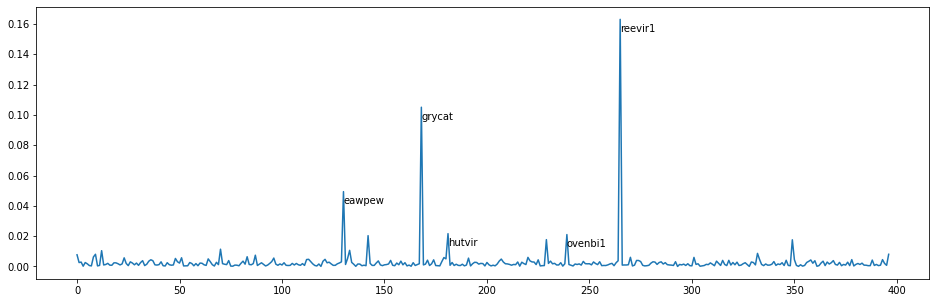

In [138]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [139]:
top5_birds

['eawpew', 'grycat', 'hutvir', 'ovenbi1', 'reevir1']

## audio_id: 7843

In [140]:
idx = valid_df[valid_df["audio_id"] == 7843].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1080,7843_SSW_5,5,nocall,nocall,mallar3,gadwal,gnwtea,0.273263
1081,7843_SSW_10,10,nocall,nocall,mallar3,warvir,grhowl,0.232884
1082,7843_SSW_15,15,nocall,nocall,mallar3,grhowl,warvir,0.052452
1083,7843_SSW_20,20,nocall,nocall,mallar3,gwfgoo,bcnher,0.221026
1084,7843_SSW_25,25,nocall,nocall,daejun,mallar3,gnwtea,0.265102
1085,7843_SSW_30,30,nocall,nocall,mallar3,grhowl,gnwtea,0.090474
1086,7843_SSW_35,35,nocall,nocall,mallar3,gwfgoo,grhowl,0.112447
1087,7843_SSW_40,40,nocall,nocall,gwfgoo,mallar3,grhowl,0.265425
1088,7843_SSW_45,45,nocall,nocall,gwfgoo,mallar3,grhowl,0.091866
1089,7843_SSW_50,50,nocall,nocall,yerwar,daejun,mallar3,0.097662


In [141]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9666666666666657

In [142]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

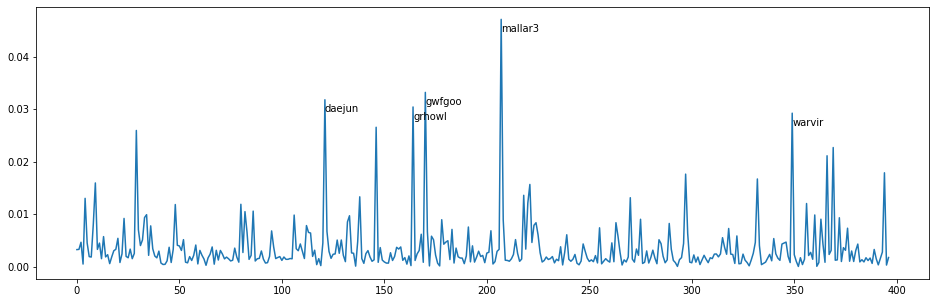

In [143]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [144]:
top5_birds

['daejun', 'grhowl', 'gwfgoo', 'mallar3', 'warvir']

In [145]:
np.argsort(oof112[1200: 1320, :].mean(0))[::-1][:3]

array([265, 168, 130])

In [146]:
np.argsort(oof112[1275, :])[::-1][:3]

array([265,  87, 239])

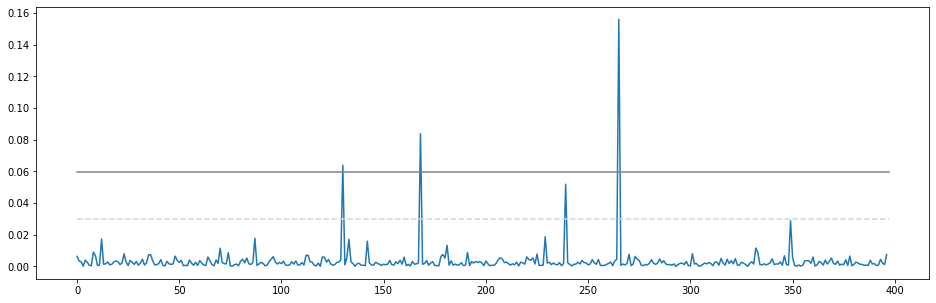

In [147]:
q = np.quantile(oof112[1200: 1320, :].mean(0), q=0.99)
q2 = q * 2

plt.figure(figsize=(16, 5))
plt.plot(oof112[1200: 1320, :].mean(0))
plt.plot([0, 397], [q, q], "--", c="lightgrey")
plt.plot([0, 397], [q2, q2], "-", c="gray")

(-0.05, 1.0)

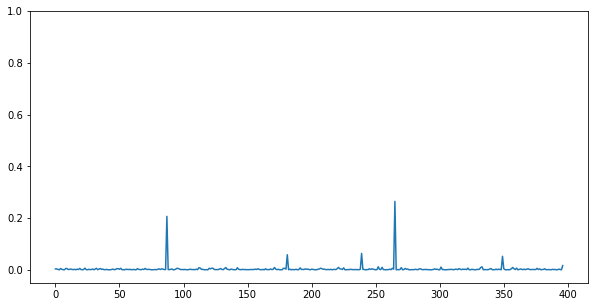

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(oof112[1275, :])
plt.ylim([-0.05, 1.0])

## audio_id: 10534

In [149]:
idx = valid_df[valid_df["audio_id"] == 10534].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1200,10534_SSW_5,5,nocall,nocall,wlswar,daejun,lazbun,0.062904
1201,10534_SSW_10,10,swaspa,swaspa,swaspa,daejun,wlswar,1.000000
1202,10534_SSW_15,15,nocall,nocall,grhowl,mallar3,gadwal,0.468732
1203,10534_SSW_20,20,nocall,nocall,grhowl,blujay,mallar3,0.999783
1204,10534_SSW_25,25,swaspa,swaspa,swaspa,daejun,chispa,0.999998
1205,10534_SSW_30,30,nocall,nocall,comgra,rewbla,gadwal,0.148773
1206,10534_SSW_35,35,nocall,nocall,rewbla,wilfly,grhowl,0.473926
1207,10534_SSW_40,40,nocall,nocall,gwfgoo,bcnher,blujay,0.529056
1208,10534_SSW_45,45,nocall,nocall,daejun,gwfgoo,mallar3,0.094898
1209,10534_SSW_50,50,blujay,nocall,blujay,grhowl,scptyr1,0.999602


In [150]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6861111111111111

In [151]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.3166666666666668

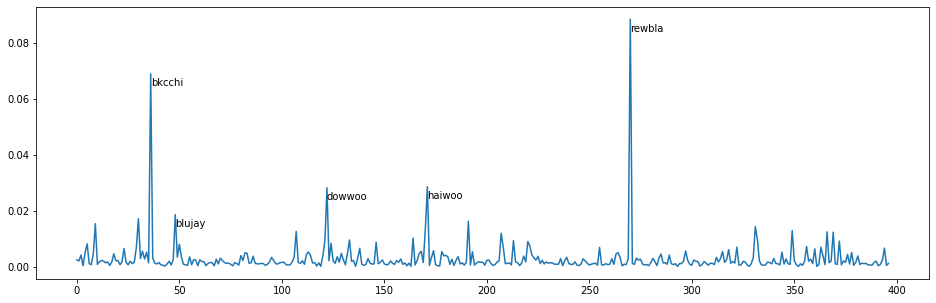

In [152]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [153]:
top5_birds

['bkcchi', 'blujay', 'dowwoo', 'haiwoo', 'rewbla']

## audio_id: 11254

In [154]:
idx = valid_df[valid_df["audio_id"] == 11254].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
0,11254_COR_5,5,rubwre1,wbwwre1,wbwwre1,orbeup1,rubwre1,1.000000
1,11254_COR_10,10,nocall,wbwwre1,wbwwre1,rubwre1,orbeup1,1.000000
2,11254_COR_15,15,rubwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,1.000000
3,11254_COR_20,20,nocall,nocall,meapar,creoro1,fepowl,0.999551
4,11254_COR_25,25,rubwre1,rubwre1,rubwre1,baywre1,wbwwre1,0.999999
5,11254_COR_30,30,nocall,nocall,burwar1,goftyr1,orbeup1,1.000000
6,11254_COR_35,35,nocall,wbwwre1,wbwwre1,rubwre1,orbeup1,0.999982
7,11254_COR_40,40,nocall,nocall,wbwwre1,bucmot2,rubwre1,0.855455
8,11254_COR_45,45,nocall,nocall,creoro1,ocbfly1,ruboro1,0.453952
9,11254_COR_50,50,nocall,nocall,wilfly,ocbfly1,creoro1,0.553085


In [155]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.8833333333333326

In [156]:
len(df[df["birds"] == "nocall"])

105

In [157]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.08888888888888888

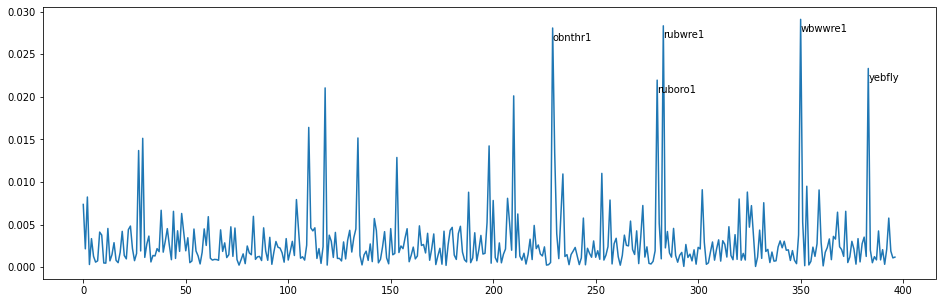

In [158]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [159]:
top5_birds

['obnthr1', 'ruboro1', 'rubwre1', 'wbwwre1', 'yebfly']

## audio_id: 18003

In [160]:
idx = valid_df[valid_df["audio_id"] == 18003].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
120,18003_COR_5,5,rucwar,rucwar,rucwar,gcrwar,spvear1,0.999990
121,18003_COR_10,10,nocall,nocall,eursta,norsho,rocpig,0.998695
122,18003_COR_15,15,nocall,nocall,eursta,lesgol,vigswa,0.981738
123,18003_COR_20,20,rucwar,rucwar,rucwar,lesvio1,cinfly2,0.999964
124,18003_COR_25,25,rucwar,nocall,laufal1,rucwar,spvear1,1.000000
125,18003_COR_30,30,rucwar,rucwar,rucwar,laufal1,gadwal,0.999999
126,18003_COR_35,35,rucwar,rucwar,rucwar,lesvio1,amered,0.999991
127,18003_COR_40,40,rucwar,rucwar,rucwar,magwar,spvear1,0.999928
128,18003_COR_45,45,rucwar,rucwar,rucwar,bucmot2,naswar,0.999967
129,18003_COR_50,50,rucwar,nocall,bucmot2,rucwar,higmot1,0.999991


In [161]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6361111111111112

In [162]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.6166666666666669

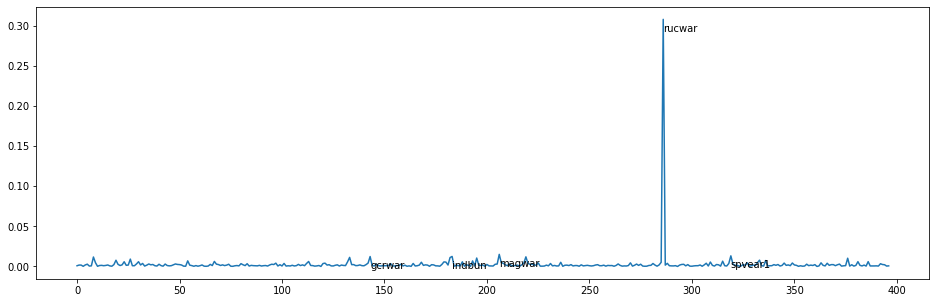

In [163]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [164]:
top5_birds

['gcrwar', 'indbun', 'magwar', 'rucwar', 'spvear1']

## audio_id: 20152

In [165]:
idx = valid_df[valid_df["audio_id"] == 20152].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1320,20152_SSW_5,5,nocall,nocall,mallar3,grhowl,bcnher,0.014314
1321,20152_SSW_10,10,nocall,nocall,mallar3,grhowl,gwfgoo,0.015237
1322,20152_SSW_15,15,nocall,nocall,mallar3,rewbla,bcnher,0.019210
1323,20152_SSW_20,20,nocall,nocall,mallar3,marwre,warvir,0.017859
1324,20152_SSW_25,25,nocall,nocall,cedwax,brncre,gockin,0.034290
1325,20152_SSW_30,30,nocall,nocall,mallar3,whimbr,grhowl,0.032495
1326,20152_SSW_35,35,nocall,nocall,mallar3,gnwtea,bcnher,0.052646
1327,20152_SSW_40,40,nocall,nocall,mallar3,yerwar,grhowl,0.035596
1328,20152_SSW_45,45,nocall,nocall,yerwar,mallar3,warvir,0.031128
1329,20152_SSW_50,50,nocall,nocall,mallar3,gwfgoo,bcnher,0.039663


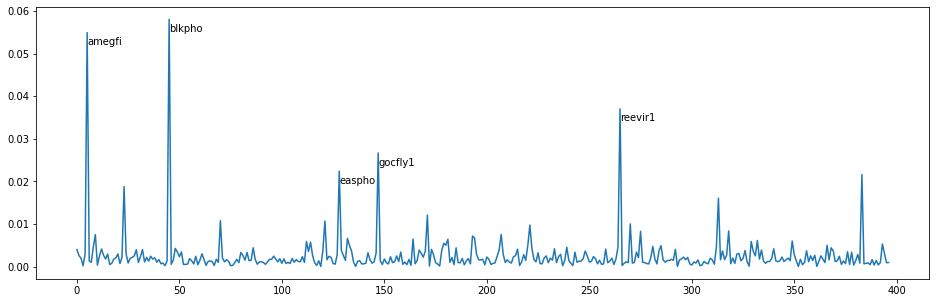

In [166]:
plot_oof(1412)

In [167]:
len(df[df["birds"] == "nocall"])

116

In [168]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9333333333333325

In [169]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

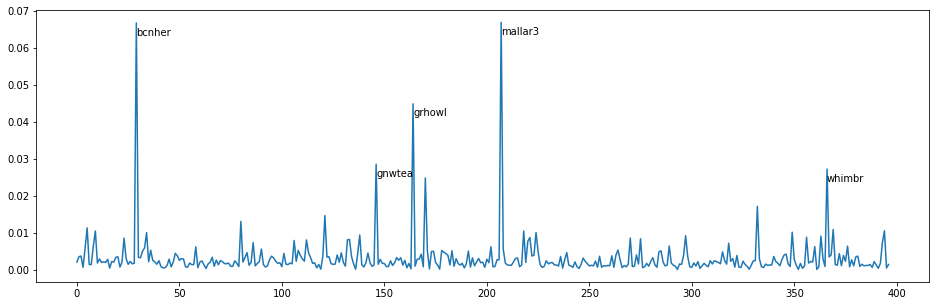

In [170]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [171]:
top5_birds

['bcnher', 'gnwtea', 'grhowl', 'mallar3', 'whimbr']

## audio_id: 21767

In [172]:
idx = valid_df[valid_df["audio_id"] == 21767].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
240,21767_COR_5,5,grekis rucwar,rucwar,rucwar,sobtyr1,banana,1.000000
241,21767_COR_10,10,grekis rucwar,rucwar,rucwar,gcrwar,magwar,0.999991
242,21767_COR_15,15,rucwar,rucwar,rucwar,thswar1,lesvio1,0.999991
243,21767_COR_20,20,rucwar,rucwar,rucwar,spvear1,magwar,0.999988
244,21767_COR_25,25,rucwar,rucwar,rucwar,grekis,magwar,0.999997
245,21767_COR_30,30,grekis rucwar,rucwar,rucwar,tenwar,thswar1,1.000000
246,21767_COR_35,35,rucwar,nocall,grekis,lesgol,rucwar,0.999997
247,21767_COR_40,40,grekis rucwar,nocall,lesvio1,rucwar,eursta,0.999994
248,21767_COR_45,45,rucwar,rucwar,rucwar,wlswar,tenwar,1.000000
249,21767_COR_50,50,nocall,rucwar,rucwar,grekis,magwar,0.999983


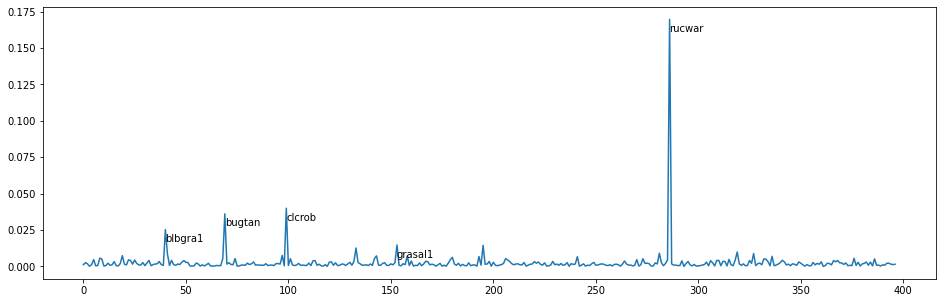

In [173]:
plot_oof(261)

In [174]:
len(df[df["birds"] == "nocall"])

22

In [175]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.3444444444444447

In [176]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.35972222222222244

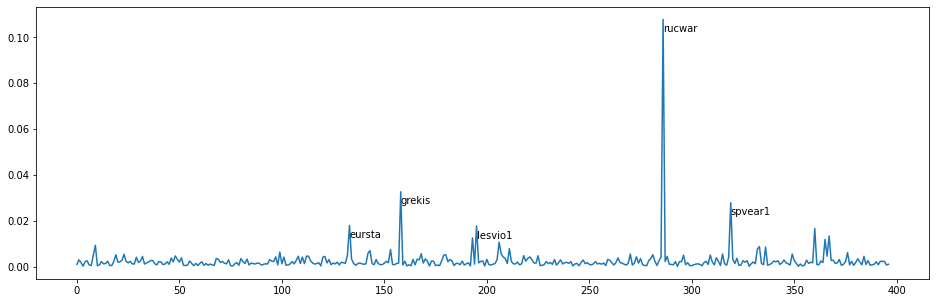

In [177]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [178]:
top5_birds

['eursta', 'grekis', 'lesvio1', 'rucwar', 'spvear1']

## audio_id: 26709

In [179]:
idx = valid_df[valid_df["audio_id"] == 26709].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1440,26709_SSW_5,5,amegfi,nocall,amegfi,daejun,vigswa,0.630631
1441,26709_SSW_10,10,nocall,nocall,mallar3,gwfgoo,bcnher,0.078197
1442,26709_SSW_15,15,nocall,nocall,warvir,mallar3,daejun,0.123547
1443,26709_SSW_20,20,nocall,nocall,warvir,daejun,mallar3,0.142551
1444,26709_SSW_25,25,nocall,nocall,mallar3,bcnher,grhowl,0.049857
1445,26709_SSW_30,30,nocall,nocall,btywar,warvir,mouwar,0.908195
1446,26709_SSW_35,35,nocall,nocall,grhowl,whimbr,bcnher,0.958917
1447,26709_SSW_40,40,nocall,nocall,grhowl,mallar3,gwfgoo,0.979407
1448,26709_SSW_45,45,nocall,nocall,mallar3,cangoo,grhowl,0.991479
1449,26709_SSW_50,50,nocall,nocall,mallar3,gwfgoo,bcnher,0.248657


In [180]:
np.max(oof[1514, :])

0.13335066481959074

In [181]:
len(df[df["birds"] == "nocall"])

62

In [182]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.06388888888888888

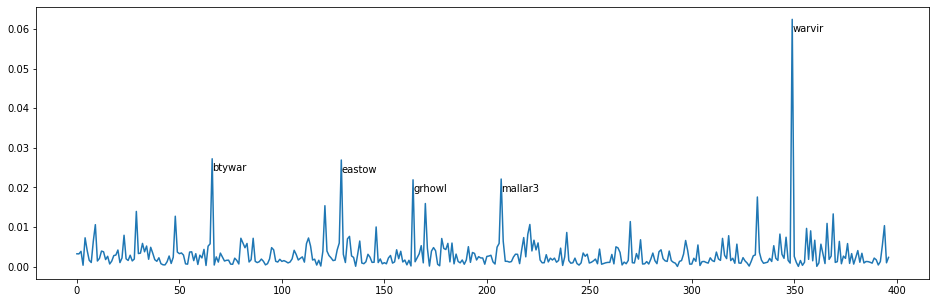

In [183]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [184]:
top5_birds

['btywar', 'eastow', 'grhowl', 'mallar3', 'warvir']

## audio_id: 26746

In [185]:
idx = valid_df[valid_df["audio_id"] == 26746].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
360,26746_COR_5,5,bobfly1,nocall,bugtan,bobfly1,strsal1,0.999987
361,26746_COR_10,10,bobfly1,bobfly1,bobfly1,ocbfly1,bugtan,0.999849
362,26746_COR_15,15,bobfly1,bobfly1,bobfly1,strfly1,grtgra,0.999764
363,26746_COR_20,20,nocall,nocall,rucwar,cinfly2,bawswa1,0.956253
364,26746_COR_25,25,nocall,bobfly1,bobfly1,whbman1,cinfly2,0.999245
365,26746_COR_30,30,bobfly1,bobfly1,bobfly1,bugtan,cobtan1,0.999991
366,26746_COR_35,35,bobfly1,bobfly1,bobfly1,bugtan,grasal1,0.999959
367,26746_COR_40,40,bobfly1 rucwar,nocall,rucwar,spvear1,thswar1,0.999930
368,26746_COR_45,45,rucwar,nocall,whbman1,plupig2,bobfly1,0.999882
369,26746_COR_50,50,rucwar,nocall,rucwar,cinfly2,amered,0.999934


In [186]:
np.max(oof[1514, :])

0.13335066481959074

In [187]:
len(df[df["birds"] == "nocall"])

71

In [188]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.175

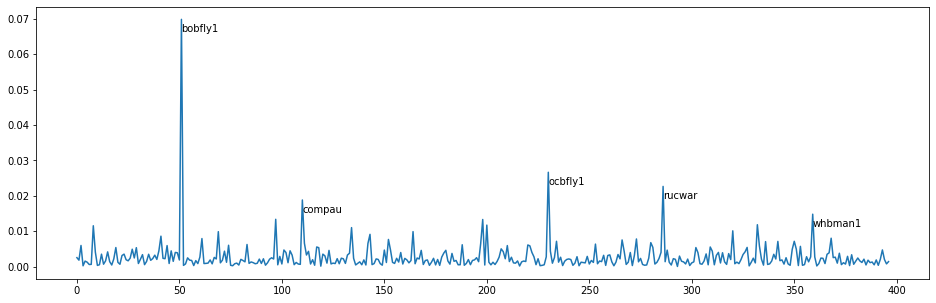

In [189]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [190]:
top5_birds

['bobfly1', 'compau', 'ocbfly1', 'rucwar', 'whbman1']

## audio_id: 28933

In [191]:
idx = valid_df[valid_df["audio_id"] == 28933].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1560,28933_SSW_5,5,sonspa,nocall,sonspa,daejun,whtspa,0.992195
1561,28933_SSW_10,10,rewbla,nocall,bnhcow,carchi,shicow,0.999893
1562,28933_SSW_15,15,sonspa,nocall,sonspa,amtspa,bnhcow,0.982426
1563,28933_SSW_20,20,sonspa,nocall,sonspa,daejun,whtspa,0.972081
1564,28933_SSW_25,25,sonspa,nocall,lesgol,rewbla,daejun,0.999655
1565,28933_SSW_30,30,sonspa,nocall,amtspa,daejun,rewbla,0.986380
1566,28933_SSW_35,35,sonspa,nocall,yerwar,sander,rewbla,0.415878
1567,28933_SSW_40,40,sonspa,nocall,amtspa,sander,yerwar,0.999983
1568,28933_SSW_45,45,sonspa,nocall,yerwar,bkcchi,amtspa,0.883064
1569,28933_SSW_50,50,sonspa,sonspa,sonspa,foxspa,whtspa,0.973487


In [192]:
np.max(oof[1514, :])

0.13335066481959074

In [193]:
len(df[df["birds"] == "nocall"])

18

In [194]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.49305555555555547

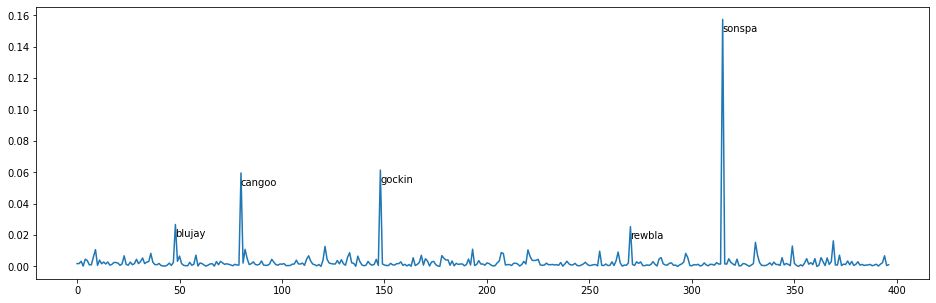

In [195]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [196]:
top5_birds

['blujay', 'cangoo', 'gockin', 'rewbla', 'sonspa']

## audio_id: 31928

In [197]:
idx = valid_df[valid_df["audio_id"] == 31928].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
480,31928_COR_5,5,nocall,nocall,compot1,grhowl,compau,0.145098
481,31928_COR_10,10,nocall,nocall,compot1,whimbr,scbwre1,0.135015
482,31928_COR_15,15,nocall,nocall,norfli,osprey,whimbr,0.999996
483,31928_COR_20,20,nocall,nocall,wilsni1,roahaw,scbwre1,1.000000
484,31928_COR_25,25,nocall,nocall,compot1,compau,grhowl,0.036316
485,31928_COR_30,30,nocall,nocall,grhowl,scbwre1,norfli,0.505340
486,31928_COR_35,35,nocall,nocall,compot1,scbwre1,cobtan1,0.999977
487,31928_COR_40,40,nocall,nocall,scbwre1,grhowl,compot1,0.999981
488,31928_COR_45,45,nocall,nocall,whimbr,grhowl,compot1,0.999988
489,31928_COR_50,50,nocall,nocall,whimbr,norfli,wilsni1,1.000000


In [198]:
np.max(oof[1514, :])

0.13335066481959074

In [199]:
len(df[df["birds"] == "nocall"])

120

In [200]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.0

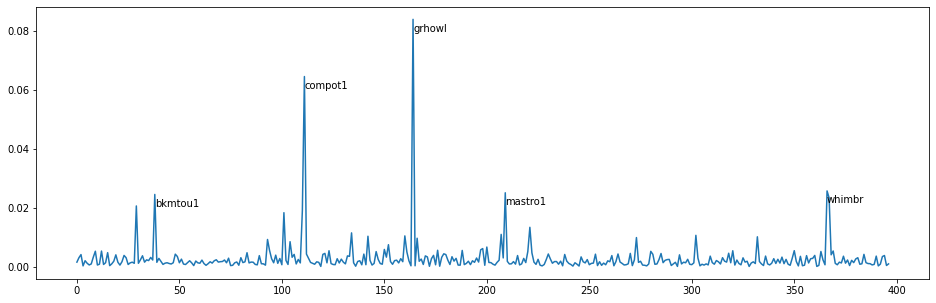

In [201]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [202]:
top5_birds

['bkmtou1', 'compot1', 'grhowl', 'mastro1', 'whimbr']

## audio_id: 42907

In [203]:
idx = valid_df[valid_df["audio_id"] == 42907].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1680,42907_SSW_5,5,reevir1,reevir1,reevir1,ovenbi1,gbwwre1,1.000000
1681,42907_SSW_10,10,reevir1,reevir1,reevir1,rocpig,eucdov,0.999998
1682,42907_SSW_15,15,reevir1,reevir1,reevir1,ovenbi1,andsol1,0.999990
1683,42907_SSW_20,20,reevir1,reevir1,reevir1,gbwwre1,ovenbi1,0.999988
1684,42907_SSW_25,25,reevir1,reevir1,reevir1,ovenbi1,gbwwre1,0.999999
1685,42907_SSW_30,30,reevir1,reevir1,reevir1,ovenbi1,tenwar,1.000000
1686,42907_SSW_35,35,reevir1,reevir1,reevir1,ovenbi1,gbwwre1,0.999995
1687,42907_SSW_40,40,reevir1,reevir1,reevir1,gbwwre1,ovenbi1,1.000000
1688,42907_SSW_45,45,reevir1,reevir1,reevir1,ovenbi1,andsol1,0.999999
1689,42907_SSW_50,50,reevir1,reevir1,reevir1,ovenbi1,tenwar,1.000000


In [204]:
np.max(oof[1514, :])

0.13335066481959074

In [205]:
len(df[df["birds"] == "nocall"])

75

In [206]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.35000000000000026

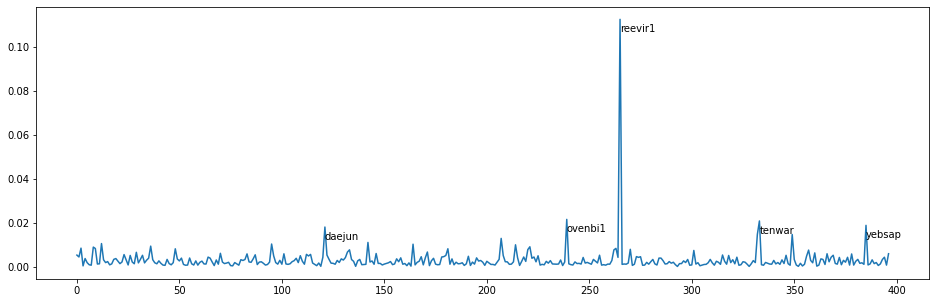

In [207]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [208]:
top5_birds

['daejun', 'ovenbi1', 'reevir1', 'tenwar', 'yebsap']

## audio_id: 44957

In [209]:
idx = valid_df[valid_df["audio_id"] == 44957].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
600,44957_COR_5,5,nocall,nocall,rudpig,cregua1,compau,0.283568
601,44957_COR_10,10,bobfly1,nocall,coltro1,littin1,chcant2,0.999294
602,44957_COR_15,15,nocall,bobfly1,bobfly1,rewbla,strfly1,0.999416
603,44957_COR_20,20,bobfly1,bobfly1,bobfly1,grekis,grtgra,0.999925
604,44957_COR_25,25,bobfly1,bobfly1,bobfly1,coohaw,blujay,0.999972
605,44957_COR_30,30,bobfly1,bobfly1,bobfly1,carwre,norcar,0.999997
606,44957_COR_35,35,bobfly1,bobfly1,bobfly1,coltro1,carwre,0.999999
607,44957_COR_40,40,bobfly1,bobfly1,bobfly1,norcar,carwre,0.999992
608,44957_COR_45,45,bobfly1,bobfly1,bobfly1,strfly1,coltro1,0.999494
609,44957_COR_50,50,bobfly1,bobfly1,bobfly1,carwre,grekis,0.999999


In [210]:
np.max(oof[1514, :])

0.13335066481959074

In [211]:
len(df[df["birds"] == "nocall"])

49

In [212]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.45277777777777845

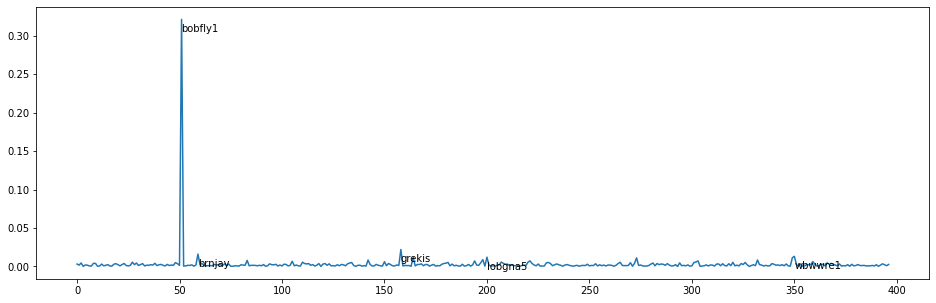

In [213]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [214]:
top5_birds

['bobfly1', 'brnjay', 'grekis', 'lobgna5', 'wbwwre1']

## audio_id: 50878

In [215]:
idx = valid_df[valid_df["audio_id"] == 50878].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
720,50878_COR_5,5,nocall,nocall,colcha1,ocbfly1,fepowl,0.993547
721,50878_COR_10,10,nocall,nocall,relpar,grhcha1,kebtou1,0.997356
722,50878_COR_15,15,nocall,nocall,grhcha1,relpar,colcha1,0.995950
723,50878_COR_20,20,nocall,nocall,grhcha1,relpar,colcha1,0.999980
724,50878_COR_25,25,nocall,nocall,relpar,grhcha1,creoro1,0.998677
725,50878_COR_30,30,nocall,nocall,colcha1,ruboro1,relpar,0.998531
726,50878_COR_35,35,nocall,nocall,grhcha1,colcha1,relpar,0.999724
727,50878_COR_40,40,nocall,nocall,grhcha1,colcha1,relpar,0.999823
728,50878_COR_45,45,nocall,nocall,grhcha1,colcha1,relpar,0.999729
729,50878_COR_50,50,nocall,nocall,colcha1,compau,ruboro1,0.995748


In [216]:
np.max(oof[1514, :])

0.13335066481959074

In [217]:
len(df[df["birds"] == "nocall"])

115

In [218]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.041666666666666664

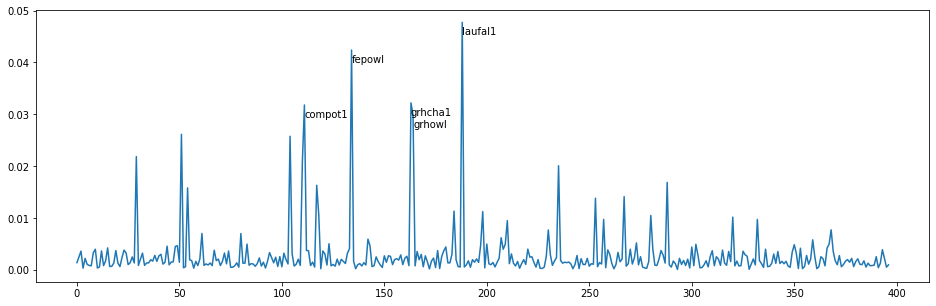

In [219]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [220]:
top5_birds

['compot1', 'fepowl', 'grhcha1', 'grhowl', 'laufal1']

## audio_id: 51010

In [221]:
idx = valid_df[valid_df["audio_id"] == 51010].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1800,51010_SSW_5,5,grycat norfli,nocall,warvir,bkcchi,norfli,0.980515
1801,51010_SSW_10,10,grycat norfli,nocall,warvir,grycat,blujay,0.999938
1802,51010_SSW_15,15,woothr,nocall,amerob,grycat,warvir,0.999983
1803,51010_SSW_20,20,norfli,nocall,lesgol,coohaw,warvir,0.999948
1804,51010_SSW_25,25,norfli,nocall,grycat,warvir,amerob,0.999882
1805,51010_SSW_30,30,nocall,nocall,rewbla,gnwtea,warvir,0.999984
1806,51010_SSW_35,35,rewbla,nocall,gnwtea,blujay,grycat,0.999975
1807,51010_SSW_40,40,nocall,nocall,blujay,grycat,bkcchi,0.999955
1808,51010_SSW_45,45,norfli,nocall,bkcchi,blujay,rewbla,0.975927
1809,51010_SSW_50,50,norfli,nocall,gnwtea,norcar,bkcchi,0.915260


In [222]:
np.max(oof[1514, :])

0.13335066481959074

In [223]:
len(df[df["birds"] == "nocall"])

28

In [224]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.4055555555555556

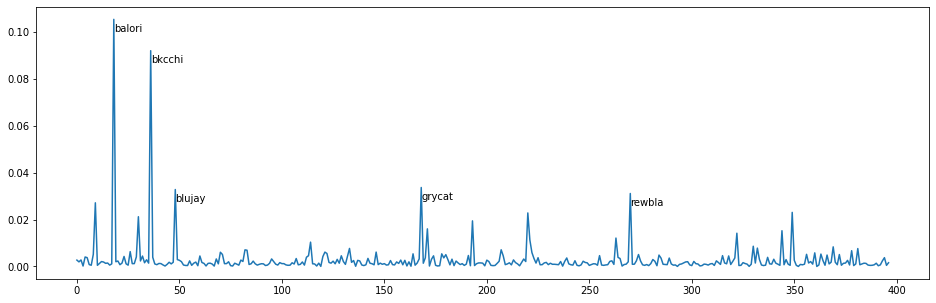

In [225]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [226]:
top5_birds

['balori', 'bkcchi', 'blujay', 'grycat', 'rewbla']

## audio_id: 54955

In [227]:
idx = valid_df[valid_df["audio_id"] == 54955].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
1920,54955_SSW_5,5,nocall,nocall,warvir,grhowl,mallar3,0.191209
1921,54955_SSW_10,10,nocall,nocall,gwfgoo,grhowl,mallar3,0.164736
1922,54955_SSW_15,15,nocall,nocall,gwfgoo,grhowl,mallar3,0.546933
1923,54955_SSW_20,20,nocall,nocall,gwfgoo,grhowl,bcnher,0.030422
1924,54955_SSW_25,25,nocall,nocall,grhowl,gwfgoo,mallar3,0.054283
1925,54955_SSW_30,30,nocall,nocall,grhowl,gwfgoo,mallar3,0.041958
1926,54955_SSW_35,35,nocall,nocall,grhowl,gwfgoo,mallar3,0.235971
1927,54955_SSW_40,40,nocall,nocall,gwfgoo,grhowl,mallar3,0.202667
1928,54955_SSW_45,45,nocall,nocall,gwfgoo,grhowl,mallar3,0.069299
1929,54955_SSW_50,50,nocall,nocall,gwfgoo,mallar3,grhowl,0.068573


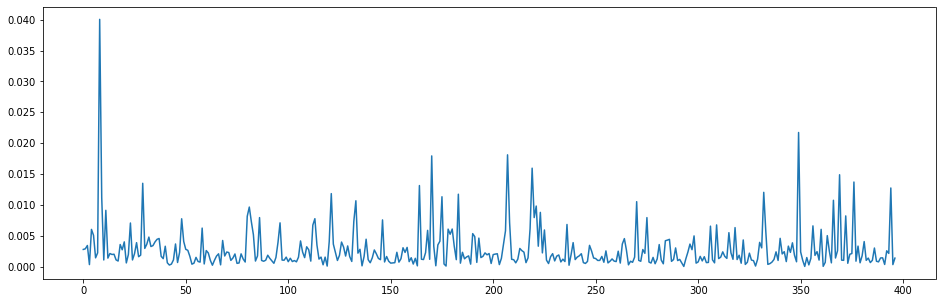

In [228]:
plt.figure(figsize=(16, 5))
plt.plot(oof[2036, :])

In [229]:
len(df[df["birds"] == "nocall"])

100

In [230]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.075

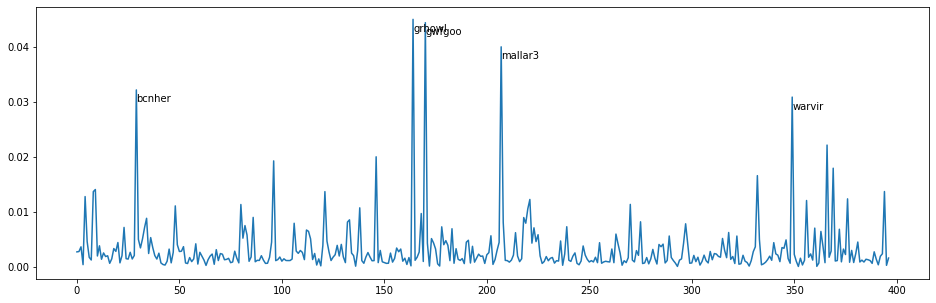

In [231]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [232]:
top5_birds

['bcnher', 'grhowl', 'gwfgoo', 'mallar3', 'warvir']

## audio_id: 57610

In [233]:
idx = valid_df[valid_df["audio_id"] == 57610].index.values
df = valid_df.loc[idx]
df[usecols]

,row_id,seconds,birds,post_oof_birds,first_label,second_label,third_label,birdcall_p
840,57610_COR_5,5,nocall,nocall,tropar,orbspa1,plupig2,0.999843
841,57610_COR_10,10,nocall,nocall,orbspa1,banana,baywre1,0.999994
842,57610_COR_15,15,nocall,nocall,orbspa1,ruboro1,meapar,0.999768
843,57610_COR_20,20,rubwre1,rubwre1,rubwre1,baywre1,wbwwre1,1.000000
844,57610_COR_25,25,rubwre1,rubwre1,rubwre1,baywre1,wbwwre1,1.000000
845,57610_COR_30,30,nocall,nocall,meapar,blhpar1,ocbfly1,0.999383
846,57610_COR_35,35,nocall,nocall,ocbfly1,lesgre1,norwat,0.984721
847,57610_COR_40,40,rubwre1,rubwre1,rubwre1,wbwwre1,burwar1,0.994006
848,57610_COR_45,45,rubwre1,rubwre1,rubwre1,wbwwre1,foxspa,0.999955
849,57610_COR_50,50,nocall,nocall,orbspa1,banana,meapar,0.999855


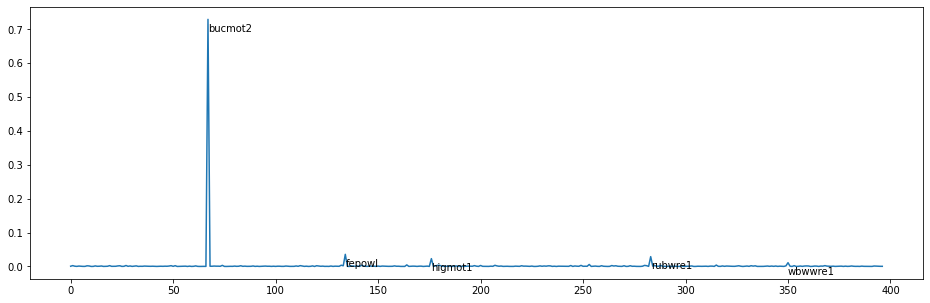

In [234]:
plot_oof(861)

In [235]:
np.max(oof[1514, :])

0.13335066481959074

In [236]:
len(df[df["birds"] == "nocall"])

93

In [237]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.18888888888888886

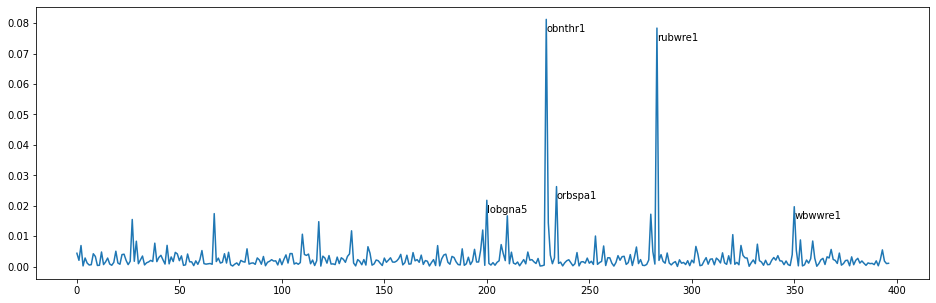

In [238]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [239]:
top5_birds

['lobgna5', 'obnthr1', 'orbspa1', 'rubwre1', 'wbwwre1']

In [240]:
valid_df["div"] = np.max(oof, axis=1) / np.sort(oof, axis=1)[:, -2]

In [241]:
valid_df[valid_df["birds"] == "nocall"].sort_values(by="div").tail(100)

,row_id,site,audio_id,seconds,birds,oof_birds,post_oof_birds,first_label,second_label,third_label,nocall_birds,nocall_oof_birds,acc,diff,diff_pattern,birdcall_p,div
6,11254_COR_35,COR,11254,35,nocall,wbwwre1,wbwwre1,wbwwre1,rubwre1,orbeup1,1,0,False,1,nocall -> bird,0.999982,4.919792
1229,10534_SSW_150,SSW,10534,150,nocall,bkcchi,bkcchi,bkcchi,mouchi,whcspa,1,0,False,1,nocall -> bird,0.291813,4.936774
1781,42907_SSW_510,SSW,42907,510,nocall,nocall,nocall,reevir1,tenwar,ovenbi1,1,1,True,0,birdX -> birdY,0.939395,4.937115
1279,10534_SSW_400,SSW,10534,400,nocall,nocall,nocall,haiwoo,blujay,rewbla,1,1,True,0,birdX -> birdY,0.838561,4.953757
1355,20152_SSW_180,SSW,20152,180,nocall,nocall,nocall,mallar3,mutswa,whimbr,1,1,True,0,birdX -> birdY,0.667812,4.961996
1341,20152_SSW_110,SSW,20152,110,nocall,nocall,nocall,mallar3,bcnher,norsho,1,1,True,0,birdX -> birdY,0.024776,5.067269
1293,10534_SSW_470,SSW,10534,470,nocall,nocall,nocall,rewbla,comgra,mallar3,1,1,True,0,birdX -> birdY,0.115507,5.177786
772,50878_COR_265,COR,50878,265,nocall,nocall,nocall,grhowl,compau,compot1,1,1,True,0,birdX -> birdY,0.999501,5.184914
752,50878_COR_165,COR,50878,165,nocall,nocall,nocall,burwar1,ocbfly1,littin1,1,1,True,0,birdX -> birdY,0.999926,5.236135
59,11254_COR_300,COR,11254,300,nocall,nocall,nocall,wilfly,orbspa1,ruboro1,1,1,True,0,birdX -> birdY,0.996790,5.284760


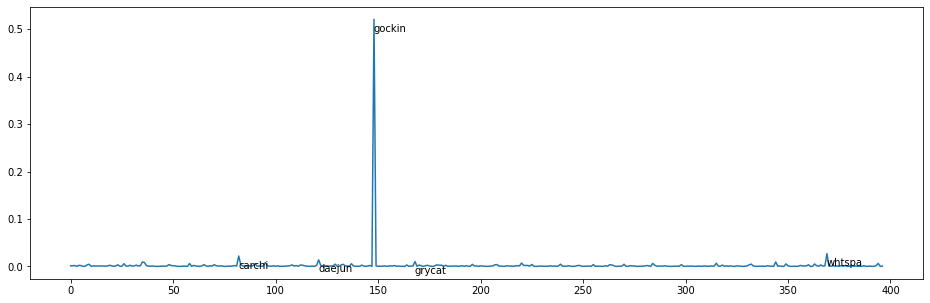

In [242]:
plot_oof(1626)

In [243]:
train_df = pd.read_csv("../data/input/train_metadata.csv")

valid_birds = []
for birds in valid_df["birds"]:
    valid_birds += birds.split(" ")
valid_birds = list(set(valid_birds))

for bird in train_df["primary_label"].unique():
    if bird in valid_birds:
        sample_num = len(train_df[train_df["primary_label"] == bird])
        print(f"【{bird}】   sample:{sample_num}")

        bird_df = valid_df[valid_df["birds"].str.contains(bird)].reset_index(drop=True)
        bird_df["acc"] = True
        true_idx = bird_df[bird_df["oof_birds"] != bird].index
        bird_df.loc[true_idx, "acc"] = False

        print(bird_df["acc"].value_counts().sort_index())
        print("\n" * 3)

【amecro】   sample:229
False    1
Name: acc, dtype: int64




【amegfi】   sample:181
False    5
True     1
Name: acc, dtype: int64




【amerob】   sample:481
False    7
Name: acc, dtype: int64




【balori】   sample:155
False    27
True     13
Name: acc, dtype: int64




【belkin1】   sample:77
False    1
True     2
Name: acc, dtype: int64




【bkcchi】   sample:272
False    41
True     26
Name: acc, dtype: int64




【blujay】   sample:328
False    9
True     3
Name: acc, dtype: int64




【bobfly1】   sample:236
False    31
True     59
Name: acc, dtype: int64




【brnjay】   sample:66
False    4
True     3
Name: acc, dtype: int64




【bucmot2】   sample:38
False    2
True     2
Name: acc, dtype: int64




【cangoo】   sample:265
False    11
True      7
Name: acc, dtype: int64




【chswar】   sample:148
False    14
True      2
Name: acc, dtype: int64




【clcrob】   sample:195
False    3
True     1
Name: acc, dtype: int64




【comgra】   sample:128
False    3
Name: acc, dtype: int64




【comyel】   samp

## 鳥

In [285]:
birds = train_df["primary_label"].unique()

for bird in birds:
    bird_df = valid_df[valid_df["birds"].str.contains(bird)]
    
    if len(bird_df) > 0:
        print(f"TRUE LABEL: {bird}")
        print("-" * 50)
        print(bird_df["post_oof_birds"].value_counts())
        print("\n" * 3)

TRUE LABEL: amecro
--------------------------------------------------
nocall    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amegfi
--------------------------------------------------
nocall    4
gockin    1
amegfi    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amerob
--------------------------------------------------
nocall    7
Name: post_oof_birds, dtype: int64




TRUE LABEL: balori
--------------------------------------------------
nocall    18
balori    15
bkcchi     6
haiwoo     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: belkin1
--------------------------------------------------
belkin1    2
rewbla     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: bkcchi
--------------------------------------------------
bkcchi     27
nocall     23
reevir1    12
grycat      5
Name: post_oof_birds, dtype: int64




TRUE LABEL: blujay
--------------------------------------------------
nocall    8
blujay    4
Name: post_oof_birds, dtype: int64




TRUE LABEL: bobfly